In [20]:
# Basic imports :
import pandas as pd
import numpy as np

# Visualization :
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Turn off warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/raw/weather_base_df.csv')

In [37]:
df['date'] = pd.to_datetime(df['date'])

## 2°/ Pre-processing :

In [ ]:
missing_values = (df['TM'].groupby(df['date'].dt.year)
                  .apply(lambda x: round(x.isnull()
                         .mean() * 100, 2)))

# Get the number of stations in activity each year
stations_in_activity = df['NUM_POSTE'].groupby(df['date'].dt.year).nunique()

# Create a dataframe to hold the missing values and stations in activity
missing_values_df = pd.DataFrame({'missing_values': missing_values, 'stations_in_activity': stations_in_activity})

missing_values_df

,missing_values,stations_in_activity
date,,
2013,64.96,3855
2014,64.85,3801
2015,64.71,3723
2016,63.92,3643
2017,62.99,3517
2018,60.85,3370
2019,54.29,3198
2020,48.73,3083
2021,27.66,2400


In [2]:
#plt.figure(figsize=(12, 6))
#sns.barplot(x=missing_values.index, y=missing_values.values)
#plt.xticks(rotation=90)
#plt.title('Percentage of Missing Values by Year in FMM')
#plt.xlabel('Year')
#plt.ylabel('Percentage of Missing Values')
#plt.show()

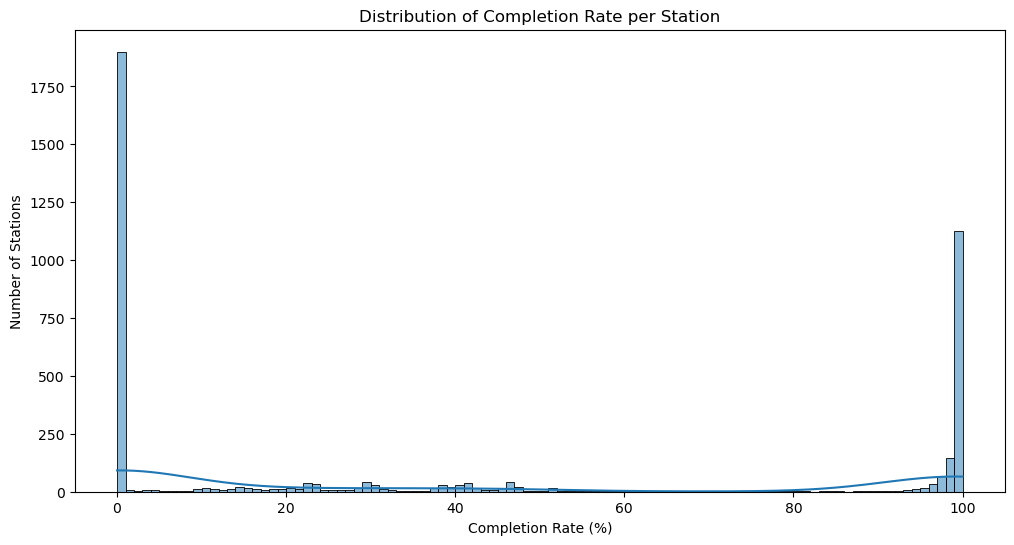

In [14]:
# Display the distribution of completion rate per station
completion_rate = df.groupby('NUM_POSTE')['TM'].apply(lambda x: x.notnull().mean() * 100)
plt.figure(figsize=(12, 6))
sns.histplot(completion_rate, bins=100, kde=True)
plt.title('Distribution of Completion Rate per Station')
plt.xlabel('Completion Rate (%)')
plt.ylabel('Number of Stations')
plt.show()

### 2.1°/ Time series :

In [ ]:
# Pipeline Time Series data
id_col = ['date', 'dept_numb', 'dept_name', 'NUM_POSTE']

# Filter by active station
completion_rate = df.groupby('NUM_POSTE')['TM'].apply(lambda x: x.notnull().mean() * 100)
df_filtered = df[id_col + ['TM']]
df_filtered = df[df['NUM_POSTE'].map(completion_rate) >= 80.0]

# Aggregate the mean between station by dept
df_agg = df_filtered.groupby(id_col[:3])['TM'].mean().reset_index()

In [ ]:
PACA = [4, 6, 13, 83, 84]

# PACA is the best region (No NaN value)
df_clean = df_agg.loc[df_agg['dept_numb'].isin(PACA)]
df_clean.head(10)

,date,dept_numb,dept_name,TM
3,2013-01-01,4,Alpes-de-Haute-Provence,0.515385
5,2013-01-01,6,Alpes-Maritimes,3.134483
12,2013-01-01,13,Bouches-du-Rhône,7.787500
81,2013-01-01,83,Var,6.626923
82,2013-01-01,84,Vaucluse,5.914286
96,2013-01-02,4,Alpes-de-Haute-Provence,1.084615
98,2013-01-02,6,Alpes-Maritimes,4.848276
105,2013-01-02,13,Bouches-du-Rhône,6.006250
174,2013-01-02,83,Var,5.738462
175,2013-01-02,84,Vaucluse,4.707143


In [23]:
# Check NaN Value
missing_values = (df_clean['TM'].groupby(df_clean['dept_name'])
                  .apply(lambda x: round(x.isnull()
                         .mean() * 100, 2)))

# Create a dataframe to hold the missing values and stations in activity
missing_values_df = pd.DataFrame({'missing_values': missing_values})

missing_values_df

,missing_values
dept_name,
Alpes-Maritimes,0.0
Alpes-de-Haute-Provence,0.0
Bouches-du-Rhône,0.0
Var,0.0
Vaucluse,0.0


In [25]:
df_clean.to_csv('datasets/processed/time_series_2013-2023.csv')

### 2.2°/ Cross section :

#### 2.2.1°/ features :

In [ ]:
def filtero_el_dataframo(df):
    """
    The goal of this function is to loop through each features of our freshly extracted dataframe to
    to extract the average of each feature by department.
    Each iteration will proceed with multiple steps :
    - Take one of the feature columns
    - Find all stations that have a 80% completion rate or above of this feature
    - Filter on a copy of the df the information columns and the feature being iterated
    - Make an average on department level on the iterated feature
    - Merge the result with the cleaned version using the "date_col
    """

    # Extracted from d_rtt & d_autre_para
    feature_available = ['RR', 'TM', 'FFM', 'GLOT', 'INST', 'UM']
    id_col = ['date', 'dept_numb', 'dept_name', 'NUM_POSTE']
    df_clean = pd.DataFrame()
    
    df = df.drop(columns = ['NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ'])

    for col in tqdm(feature_available, desc = "Columns processed : "):
        
        # Filtering
        completion_rate = df.groupby('NUM_POSTE')[col].apply(lambda x: x.notnull().mean() * 100)
        df_filtered = df[id_col + [col]]
        df_filtered = df[df['NUM_POSTE'].map(completion_rate) >= 80.0]
        #print("filtering done")

        # Aggregation
        df_agg = df_filtered.groupby(id_col[:3])[col].mean().reset_index()
        #print("Aggregation done")

        # Merging
        if df_clean.empty:
            df_clean = df_agg
        else:
            df_clean = pd.merge(df_clean, df_agg, on = id_col[:3], how = 'left')
        #print("Merging done")

        df_clean = df_clean.sort_values('date')
        
    return df_clean


In [98]:
df_filtered = filtero_el_dataframo(df)
df_filtered.head()

Columns processed : 100%|██████████| 6/6 [00:28<00:00,  4.68s/it]


,date,dept_numb,dept_name,RR,TM,FFM,GLOT,INST,UM
0,2013-01-01,1,Ain,14.455814,5.110000,2.033333,98.5,0.000000,89.5000
1,2013-01-01,2,Aisne,1.348387,6.037500,4.828571,356.0,245.000000,90.0000
2,2013-01-01,3,Allier,4.239216,6.252632,3.760000,134.0,13.333333,85.8750
3,2013-01-01,4,Alpes-de-Haute-Provence,5.313889,0.515385,1.266667,89.0,0.000000,89.0000
4,2013-01-01,5,Hautes-Alpes,3.705357,-1.894118,1.531250,170.0,0.000000,77.1875


In [99]:
feature_available = ['RR', 'TM', 'FFM', 'GLOT', 'INST', 'UM']
missing_values_df = pd.DataFrame()

for col in feature_available:
       missing_values = (df_filtered[col].groupby(df_filtered['dept_name'])
                     .apply(lambda x: round(x.isnull()
                            .mean() * 100, 2)))

       missing_values_df[col] = pd.DataFrame({'missing_values': missing_values})

missing_values_df

,RR,TM,FFM,GLOT,INST,UM
dept_name,,,,,,
Ain,0.0,0.0,0.00,0.00,0.00,0.0
Aisne,0.0,0.0,0.02,0.22,0.17,0.0
Allier,0.0,0.0,0.00,0.00,0.00,0.0
Alpes-Maritimes,0.0,0.0,0.00,0.00,0.00,0.0
Alpes-de-Haute-Provence,0.0,0.0,0.00,0.42,0.17,0.0
...,...,...,...,...,...,...
Vendée,0.0,0.0,0.00,0.00,0.00,0.0
Vienne,0.0,0.0,0.00,0.00,0.00,0.0
Vosges,0.0,0.0,0.00,0.00,0.00,0.0


In [ ]:
region_da_merdo = []

for col in missing_values_df.columns:
    temp = missing_values_df.loc[missing_values_df[col] >= 20] # 20% number of NaN value 
    [region_da_merdo.append(el) for el in list(temp.index)]

region_da_merdo = set(region_da_merdo)
region_da_merdo

{'Haute-Savoie',
 'Hauts-de-Seine',
 'Loire',
 'Nièvre',
 'Nord',
 'Seine-Maritime',
 'Seine-Saint-Denis',
 'Territoire_de_Belfort',
 'Val-de-Marne'}

In [ ]:
df_clean = df_filtered[~df_filtered['dept_name'].isin(region_da_merdo)]

In [146]:
season = [
    '02-01', # Spring
    '05-01', # Summer
    '08-01', # Fall
    '11-01'  # Winter
]

df_smoll = df_clean[df_clean['date'].dt.strftime('%m-%d').isin(season)]
df_smoll.head()

,date,dept_numb,dept_name,RR,TM,FFM,GLOT,INST,UM
2914,2013-02-01,1,Ain,20.323810,7.630000,2.700000,112.5,0.0,90.833333
2915,2013-02-01,2,Aisne,5.609677,6.525000,4.585714,100.0,0.0,93.625000
2916,2013-02-01,3,Allier,10.740000,9.255556,5.040000,166.0,0.0,85.000000
2917,2013-02-01,4,Alpes-de-Haute-Provence,4.708333,6.784615,2.377778,609.0,95.0,74.000000
2918,2013-02-01,5,Hautes-Alpes,11.780000,1.982353,2.412500,424.0,7.0,84.625000


There is 10 NaN values in the 'INST' column (8 in Marne, 1 in Yvelines and 1 in Tarn-et-Garonne).  
Then 3 NaN values in the 'GLOT' column (2 in Tarn-et-Garonne and 1 in Lot)

In [147]:
df_smoll.isna().sum()

date          0
dept_numb     0
dept_name     0
RR            0
TM            0
FFM           0
GLOT          3
INST         10
UM            0
dtype: int64

In [ ]:
mean_GLOT = df_smoll['GLOT'].mean()
mean_INST = df_smoll['INST'].mean()

df_smoll['INST'] = df_smoll['INST'].fillna(mean_INST)
df_smoll['GLOT'] = df_smoll['GLOT'].fillna(mean_GLOT)

In [ ]:
#df_smoll.to_csv('datasets/processed/cross_section_2013-2023.csv')

#### 2.2.2°/ Energy df :

The best energy dataset source <a href = "https://www.data.gouv.fr/organizations/open-data-reseaux-energies-1/">ODRE</a>

ALL PRAISE DA LORDO, THIS ONE GOT NO EMPTY ROWS

In [ ]:
#df_elec = pd.read_csv('datasets/raw/elec_consumption.csv', index_col = 0).reset_index(drop = True)
#df_features = pd.read_csv('datasets/midway/cross_section_features.csv', index_col = 0).reset_index(drop = True)

In [ ]:
#df_elec['date'] = pd.to_datetime(df_elec['Date'])
#df_elec = df_elec[df_elec['Région'] == "Provence-Alpes-Côte d'Azur"]
#
#df_elec['total_energy_consumption_MW'] = (
#    df_elec['Consommation brute gaz totale (MW PCS 0°C)'] +
#    df_elec['Consommation brute électricité (MW) - RTE']
#)
#
#df_elec = df_elec.groupby('date')['total_energy_consumption_MW'].sum().reset_index()
#
#df_elec = df_elec.loc[df_elec['date'] >= '2015-01-01']

In [ ]:
#df_merge = df_features.groupby('date')[['RR', 'TM', 'FFM', 'GLOT', 'INST', 'UM']].sum().reset_index()
#df_merge = pd.merge(df_merge, df_elec, on = ['date'], how = 'left')
#df_merge = df_merge.set_index('date')
#df_merge = df_merge.sort_index()

In [ ]:
## ==========================================================================================================
## == Download the dataframe when the cleaning is done, so that you don't need to rerun the whole processs ==
## ==========================================================================================================
#
#df_clean.to_csv("datasets/Weather_data_2015-2025_by_dept.csv", index=False)
#df_merge.to_csv("datasets/final_dataset.csv", index=False)

### 2.3°/ Explanatory data analysis :

In [64]:
df_cs = pd.read_csv('datasets/processed/cross_section_2013-2023.csv', index_col = 0).reset_index(drop = True)
df_ts = pd.read_csv('datasets/processed/time_series_2013-2023.csv', usecols = ['date', 'dept_name', 'TM'])

In [65]:
df_ts['date'] = pd.to_datetime(df_ts['date'])
df_ts = df_ts.set_index('date')

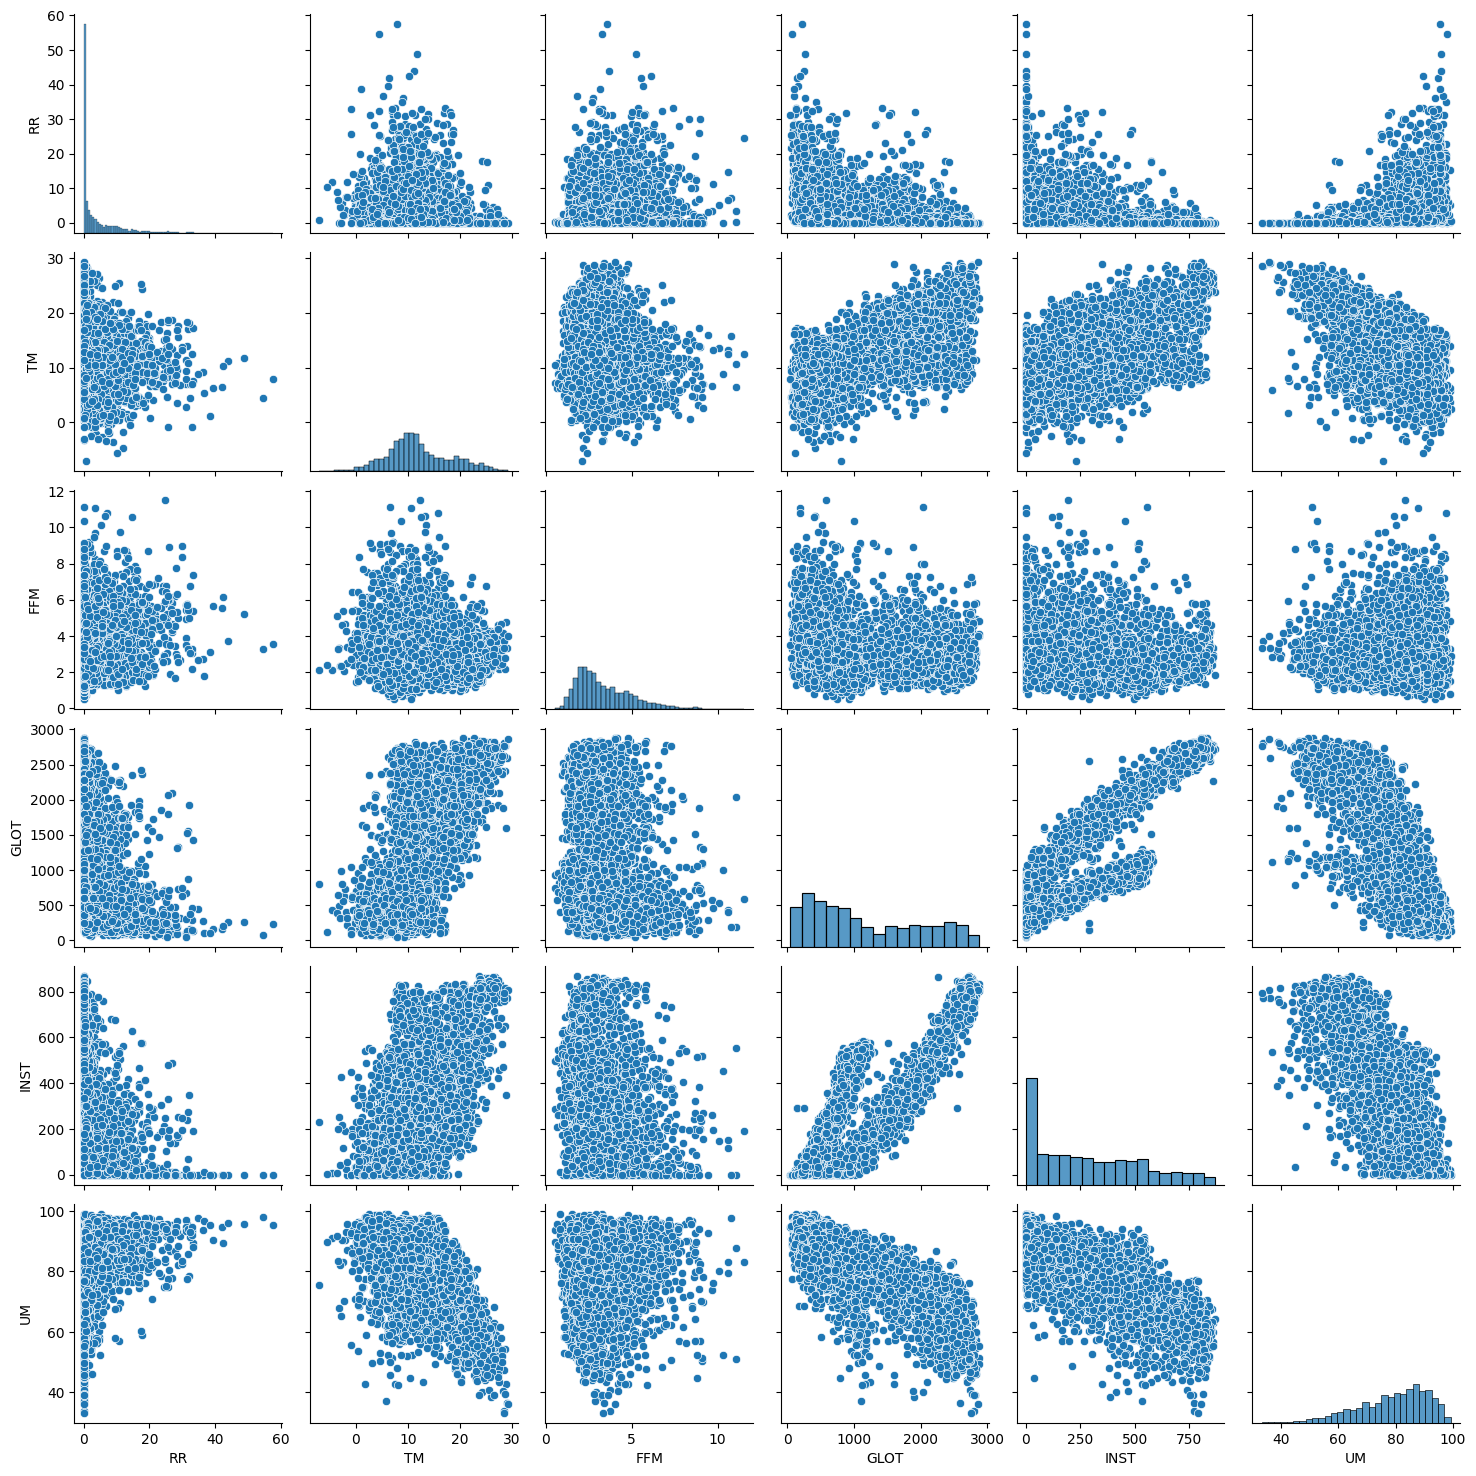

In [27]:
sns.pairplot(df_cs[['RR', 'TM', 'FFM', 'GLOT', 'INST', 'UM']])
plt.show()

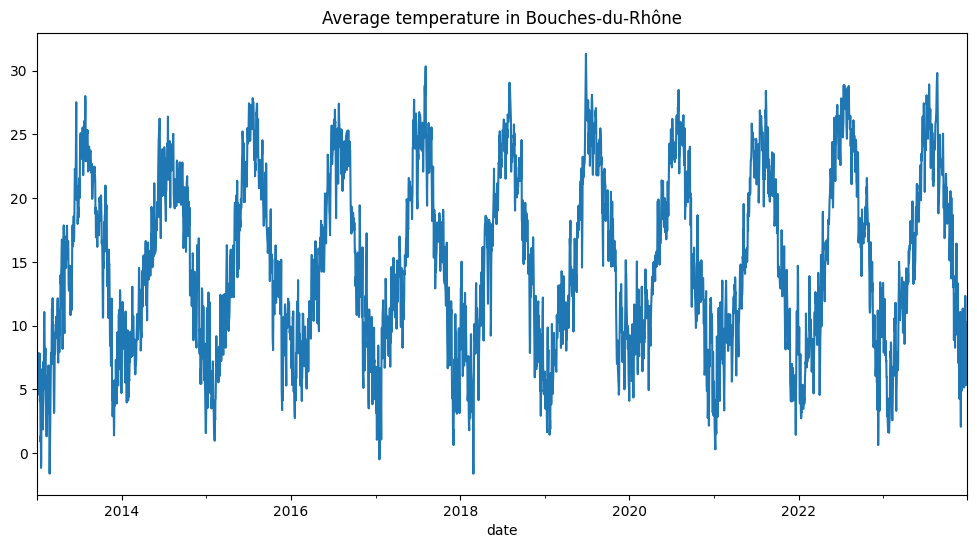

In [ ]:
dept = 'Bouches-du-Rhône'

df_ts[df_ts['dept_name'] == dept]['TM'].plot(figsize=(12,6))
plt.title(f'Average temperature in {dept}')
plt.show()